# Evaluating ViTs
## Chapter 6 Module 2
In this module, we will be covering how we can perform basic evaluation on most types of ViTs. One of the great parts of FiftyOne is that once your data and model predictions are in FiftyOne, evaluation becomes easy, no matter if you are coming from different formats. Gone are the days of converting your YOLO styled predictions to COCO styled evaluation, FiftyOne handles all the conversions for you so you can focus on the task at hand.

Let's take a look first at loading a common a dataset with predictions.

### Installation

Here are some packages that are needed to help run some of our demo code:

In [ ]:
pip install torch  pycocotools transformers timm

## Loading a Zoo Dataset for Evaluation
We will be loading the [`quickstart`](https://docs.voxel51.com/dataset_zoo/datasets.html#quickstart) dataset from the [Dataset Zoo](https://docs.voxel51.com/dataset_zoo/index.html). This dataset is a slice of MSCOCO and contains some preloaded predictions. If you are unsure how to load your own detection dataset, be sure to checkout our Getting Started with Detections [LINK]

Once our dataset is loaded, we can start getting ready for model eval!

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    max_samples=25,
)


# View summary info about the dataset
print(dataset)

Found annotations at '/Users/dangural/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation-25'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Name:        coco-2017-validation-25
Media type:  image
Num samples: 25
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


Before we go further, let’s launch the [FiftyOne App](https://docs.voxel51.com/user_guide/app.html) and use the GUI to explore the dataset visually:


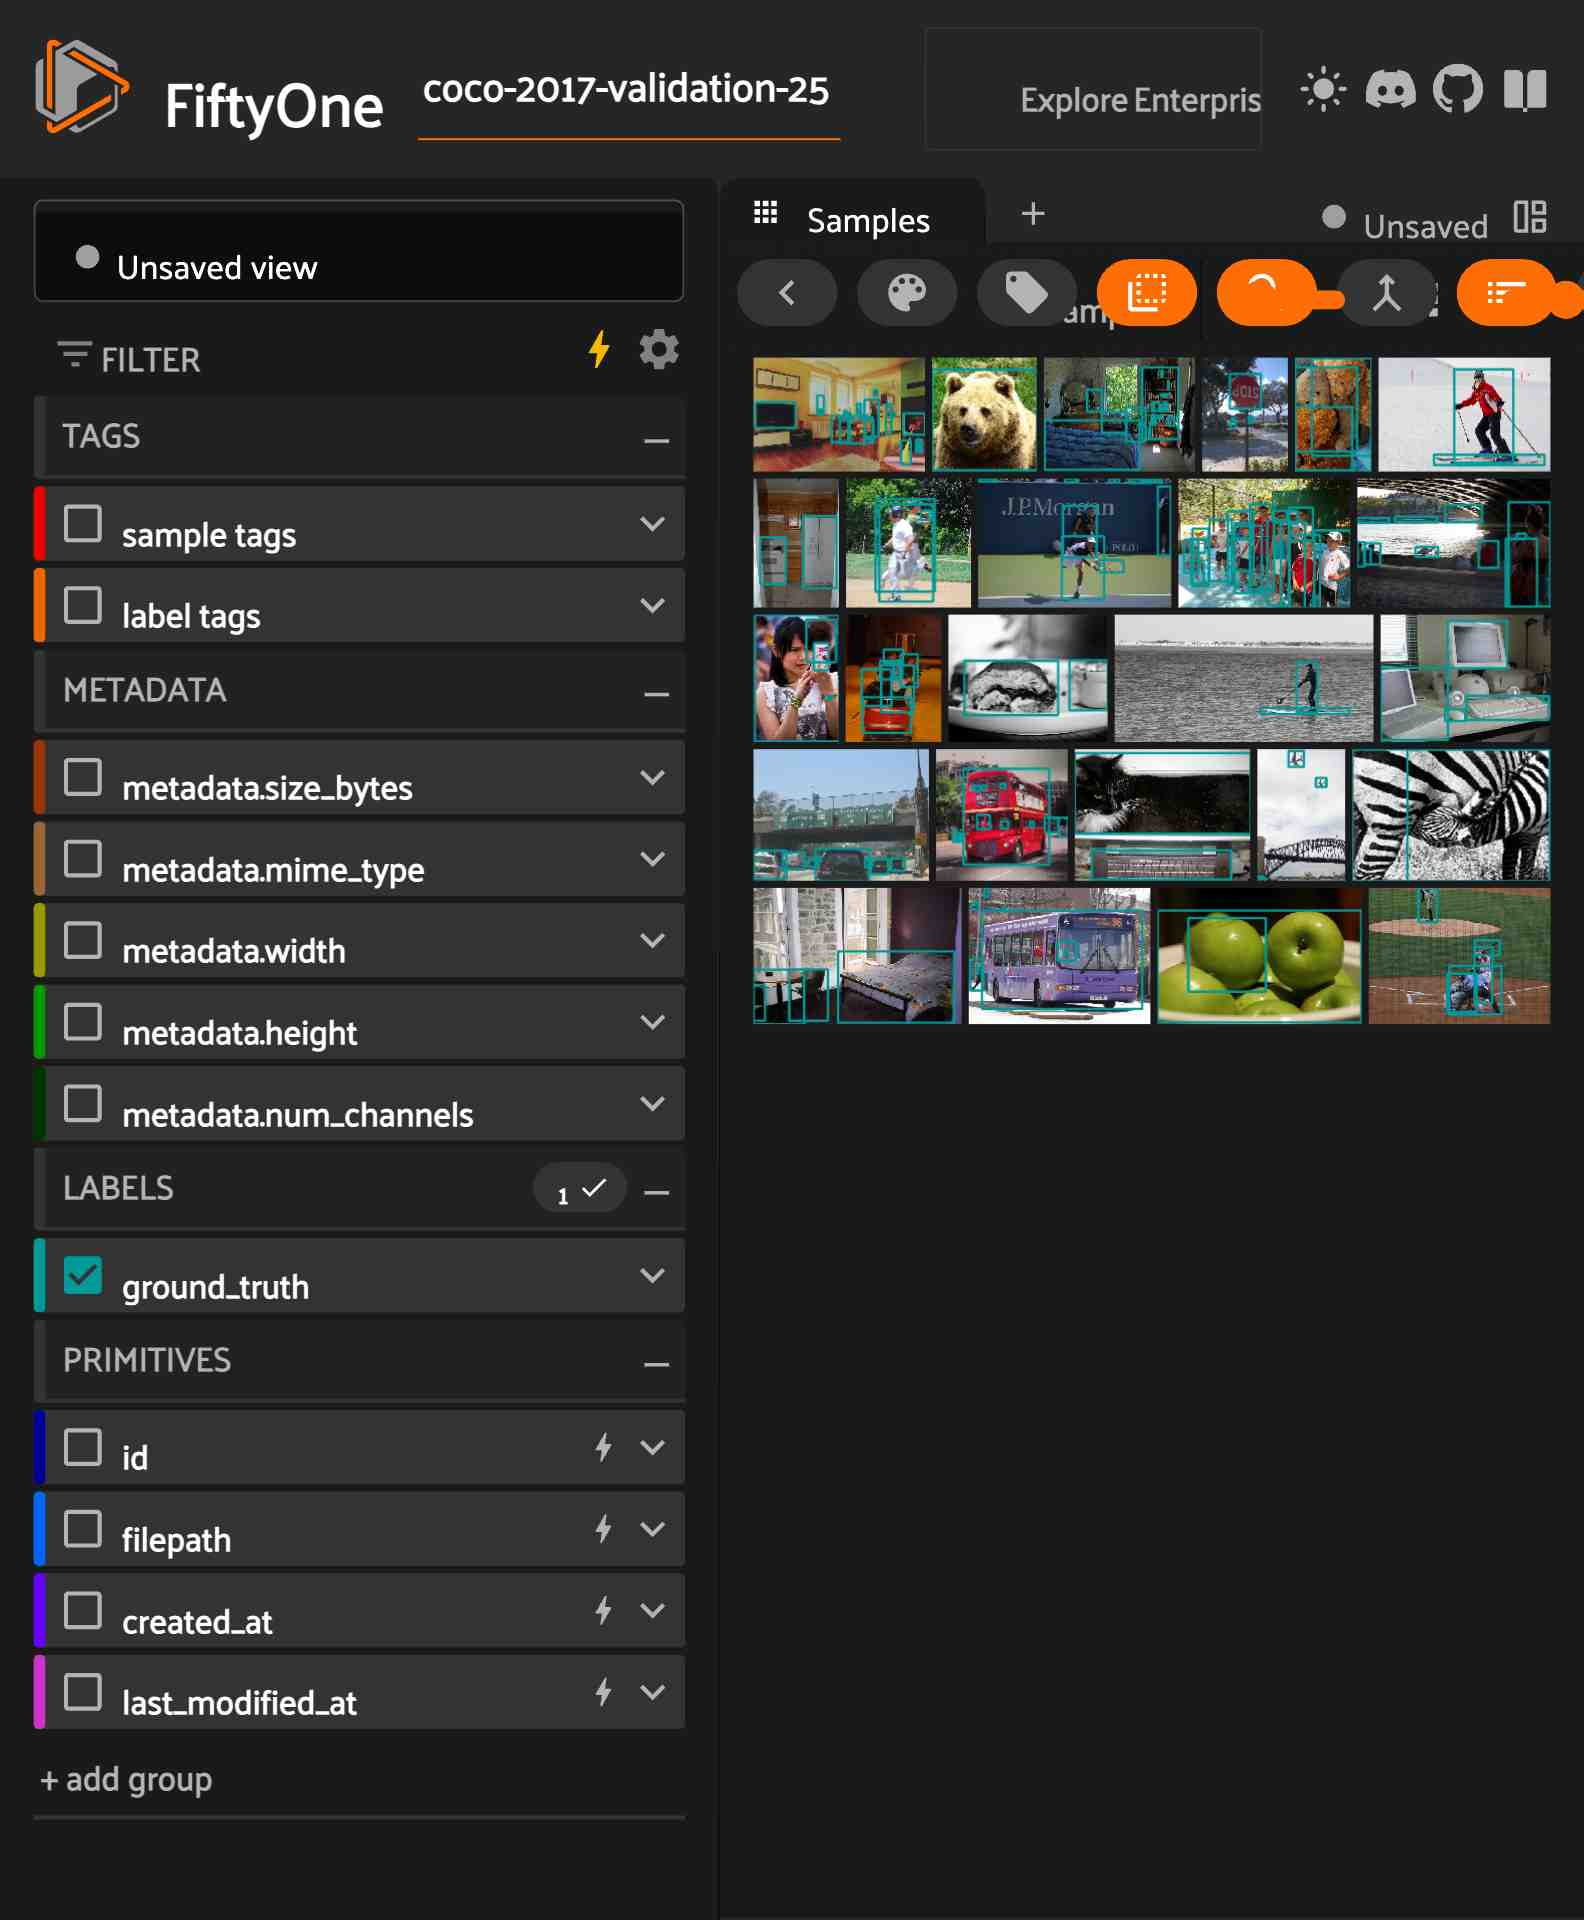

In [2]:
session = fo.launch_app(dataset)

## Evaluate Detections

Now that we have samples with ground truth and predicted objects, let’s use FiftyOne to evaluate the quality of the detections.

FiftyOne provides a powerful [evaluation API](https://docs.voxel51.com/user_guide/evaluation.html) that contains a collection of methods for performing evaluation of model predictions. Since we’re working with object detections here, we’ll use [detection evaluation](https://docs.voxel51.com/user_guide/evaluation.html#detections).

We can run evaluation on our samples via [`evaluate_detections()`](https://docs.voxel51.com/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.evaluate_detections). Note that this method is available on both the `Dataset` and `DatasetView` classes, which means that we can run evaluation on subsets of our dataset as well.

By default, this method will use the COCO evaluation protocol, plus some extra goodies that we will use later.

In [3]:
from transformers import DetrForObjectDetection
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50"
)

dataset.apply_model(model, label_field="det_predictions")

results = dataset.evaluate_detections(
    "det_predictions",
    gt_field="ground_truth",
    eval_key="eval_det",
    compute_mAP=True,
)

/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/torch/nn/modules/module.py:2409: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/torch/nn/modules/module.py:2409: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their

 100% |███████████████████| 25/25 [9.4s elapsed, 0s remaining, 2.8 samples/s]       
Evaluating detections...
 100% |███████████████████| 25/25 [258.6ms elapsed, 0s remaining, 96.7 samples/s]     
Performing IoU sweep...
 100% |███████████████████| 25/25 [144.3ms elapsed, 0s remaining, 173.3 samples/s]     


## Analyzing Results

The `results` object returned by the evaluation routine provides a number of convenient methods for analyzing our predictions.

For example, let’s print a classification report for the top-10 most common classes in the dataset:

In [4]:
# Get the 10 most common classes in the dataset
counts = dataset.count_values("ground_truth.detections.label")
classes_top10 = sorted(counts, key=counts.get, reverse=True)[:10]

# Print a classification report for the top-10 classes
results.print_report(classes=classes_top10)

              precision    recall  f1-score   support

      person       0.64      0.89      0.74        61
        book       0.98      0.86      0.92        72
         car       0.50      0.75      0.60         8
       chair       0.86      0.75      0.80         8
         bus       1.00      1.00      1.00         4
        vase       0.25      0.50      0.33         4
          tv       1.00      1.00      1.00         3
        boat       0.18      0.67      0.29         3
         bed       1.00      0.67      0.80         3
     handbag       1.00      0.33      0.50         3

   micro avg       0.73      0.84      0.78       169
   macro avg       0.74      0.74      0.70       169
weighted avg       0.80      0.84      0.80       169



Notice that is also gave us several average evaluation metrics each class along with summary metrics for only these 10 classes. The support column is the actual number of detections for that class. You can learn more by checking out `sklearn`'s [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) which is what is being leveraged under the hood!

We can also grab the mean average-precision (mAP) of our model as well:

In [5]:
print(results.mAP())

0.5063002184465007


## Evaluate Subsets

As mentioned before, we can evaluate `DatasetViews` as well! Let's evaluate only where our model is highly confident. First we will create a high confidence view, then evaluate with `evaluate_detections()` again. See using [Dataset Views](https://docs.voxel51.com/user_guide/using_views.html) for full details on matching, filtering, or sorting detections.  

In [7]:
from fiftyone import ViewField as F

# Only contains detections with confidence >= 0.75
high_conf_view = dataset.filter_labels("det_predictions", F("confidence") > 0.75, only_matches=False)

# Print some information about the view
print(high_conf_view)

Dataset:     coco-2017-validation-25
Media type:  image
Num samples: 25
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    det_predictions:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    eval_det_tp:      fiftyone.core.fields.IntField
    eval_det_fp:      fiftyone.core.fields.IntField
    eval_det_fn:      fiftyone.core.fields.IntField
View stages:
    1. FilterLabels(field='det_predictions', filter={'$gt': ['$$this.confidence', 0.75]}, only_matches=False, trajectories=False)


We can check out our new view in the session before we run evaluation:


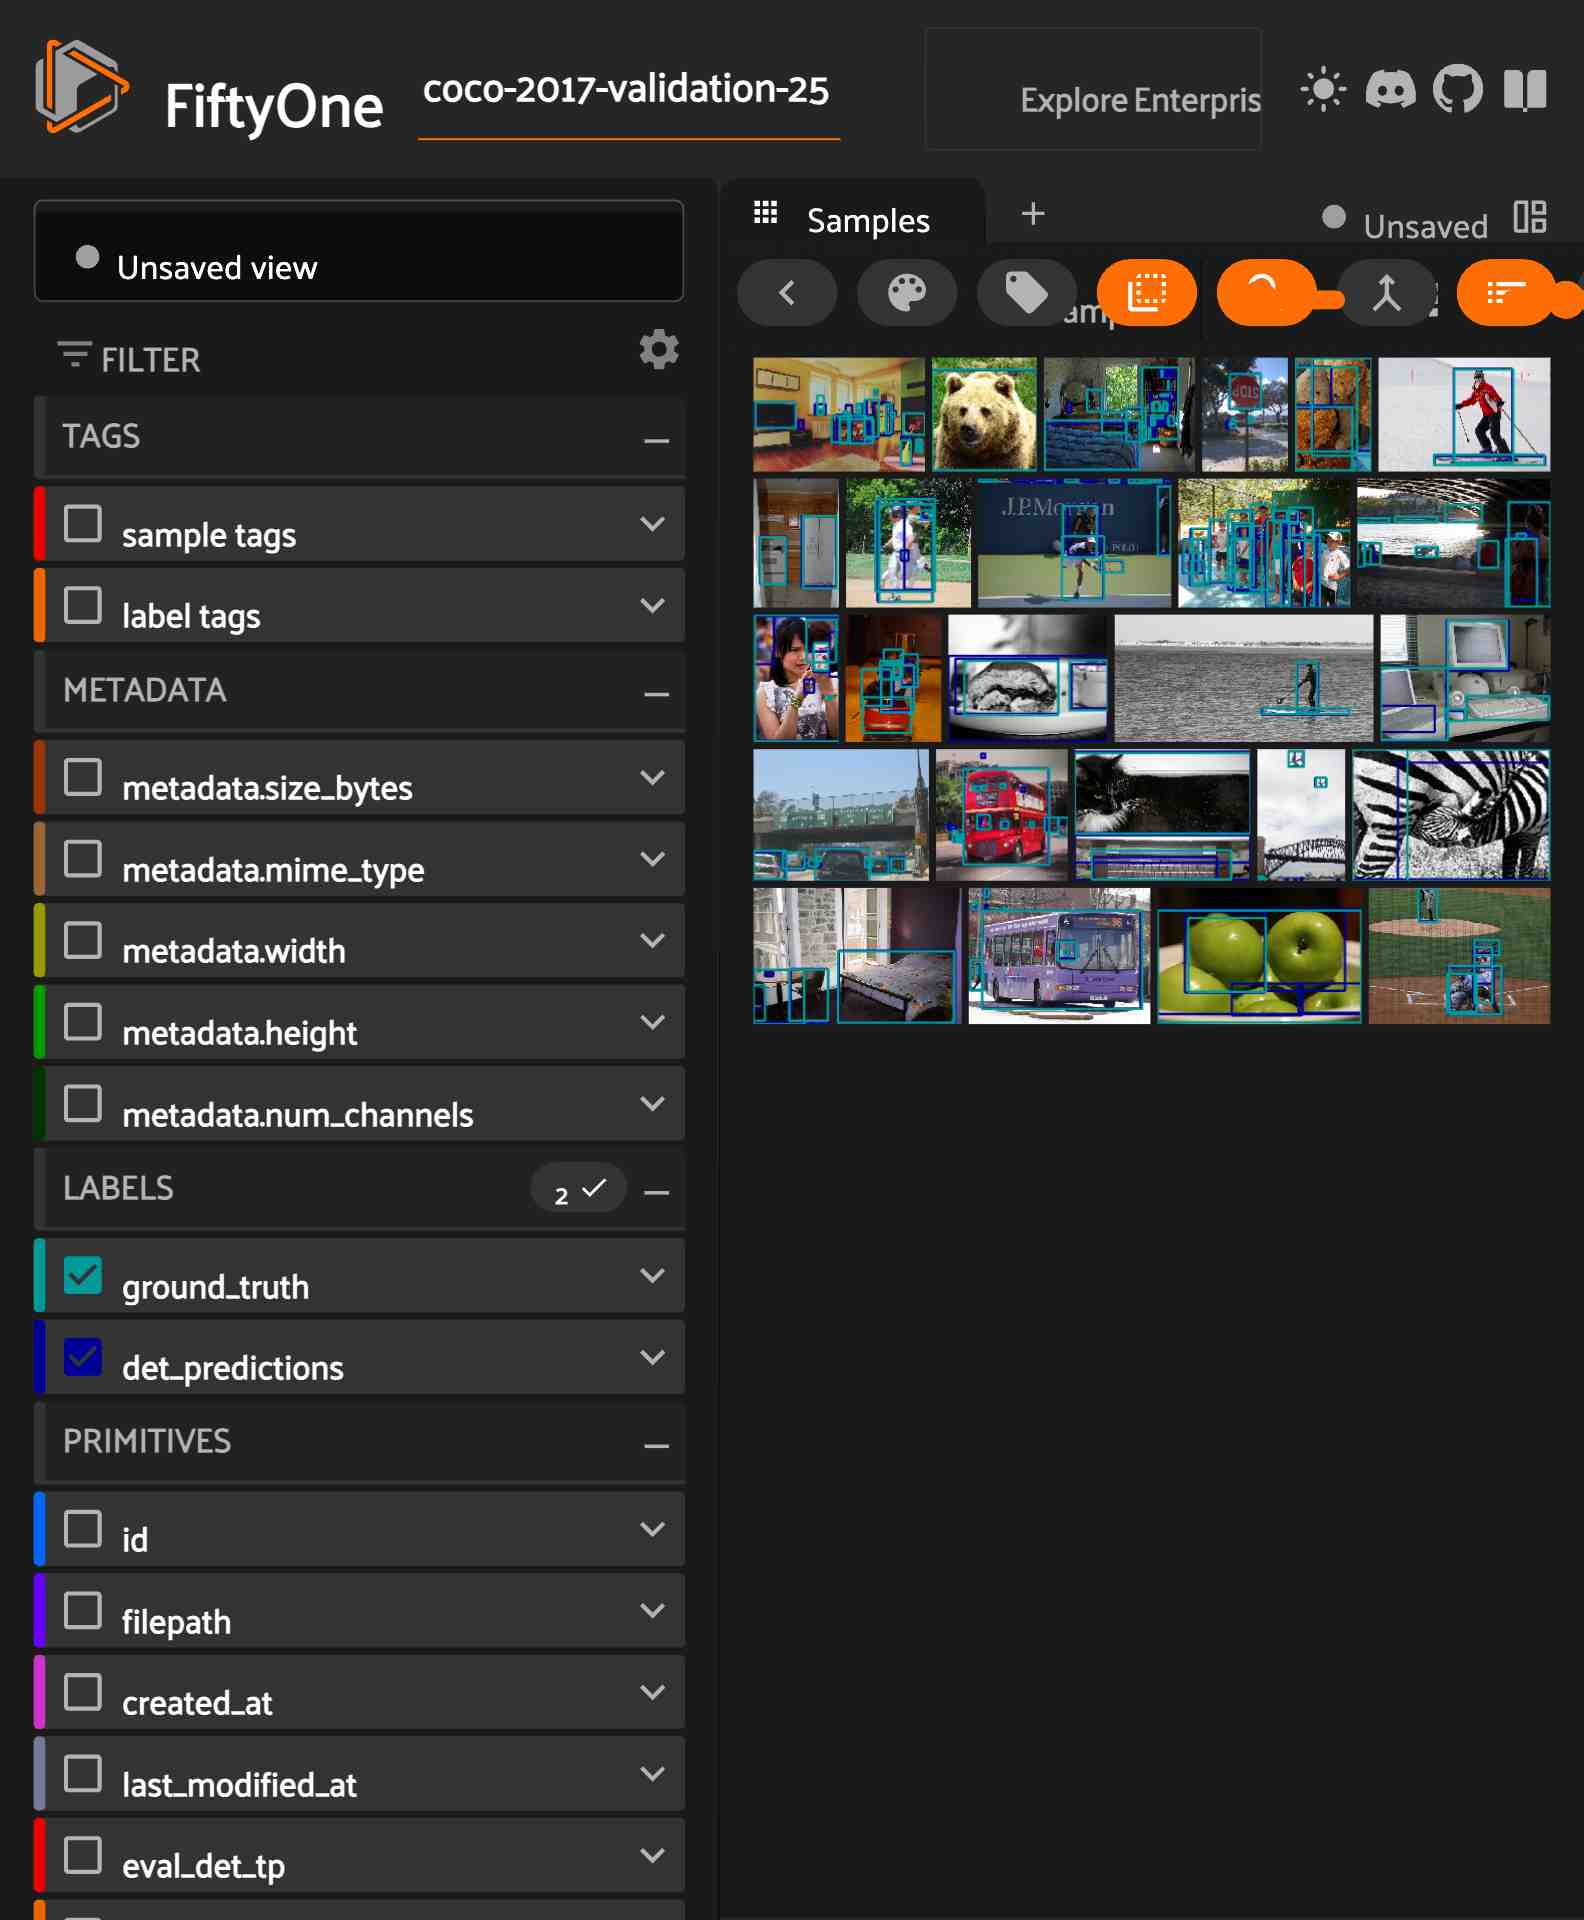

In [ ]:
session.view = high_conf_view

Just like before, lets run evaluation. Be sure to change the eval_key to a new name this time!

In [10]:
results = high_conf_view.evaluate_detections(
    "det_predictions",
    gt_field="ground_truth",
    eval_key="eval_high_conf",
    compute_mAP=True,
)

# Print the same report to see the difference
results.print_report(classes=classes_top10)
print(results.mAP())

Evaluating detections...
 100% |███████████████████| 25/25 [161.4ms elapsed, 0s remaining, 154.9 samples/s]      
Performing IoU sweep...
 100% |███████████████████| 25/25 [140.8ms elapsed, 0s remaining, 177.5 samples/s]     
              precision    recall  f1-score   support

      person       0.77      0.84      0.80        61
        book       1.00      0.68      0.81        40
         car       0.60      0.75      0.67         8
       chair       0.86      0.75      0.80         8
         bus       1.00      1.00      1.00         4
        vase       0.40      0.50      0.44         4
          tv       1.00      0.67      0.80         3
        boat       0.17      0.33      0.22         3
         bed       1.00      0.67      0.80         3
     handbag       1.00      0.33      0.50         3

   micro avg       0.78      0.74      0.76       137
   macro avg       0.78      0.65      0.68       137
weighted avg       0.83      0.74      0.77       137

0.4841572452431

## Evaluate for Classification

Evaluation is just as easy for classification tasks. Once you have loaded up your dataset and model predictions, you can start with `dataset.evaluate_classifications()`

Overwriting existing directory '/Users/dangural/fiftyone/cifar10/test'


100%|██████████| 170M/170M [00:04<00:00, 37.1MB/s] 


 100% |█████████████| 10000/10000 [1.3s elapsed, 0s remaining, 7.5K samples/s]         
Dataset info written to '/Users/dangural/fiftyone/cifar10/info.json'
Loading 'cifar10' split 'test'
 100% |█████████████| 10000/10000 [1.6s elapsed, 0s remaining, 6.2K samples/s]         
Dataset 'cifar10-test' created



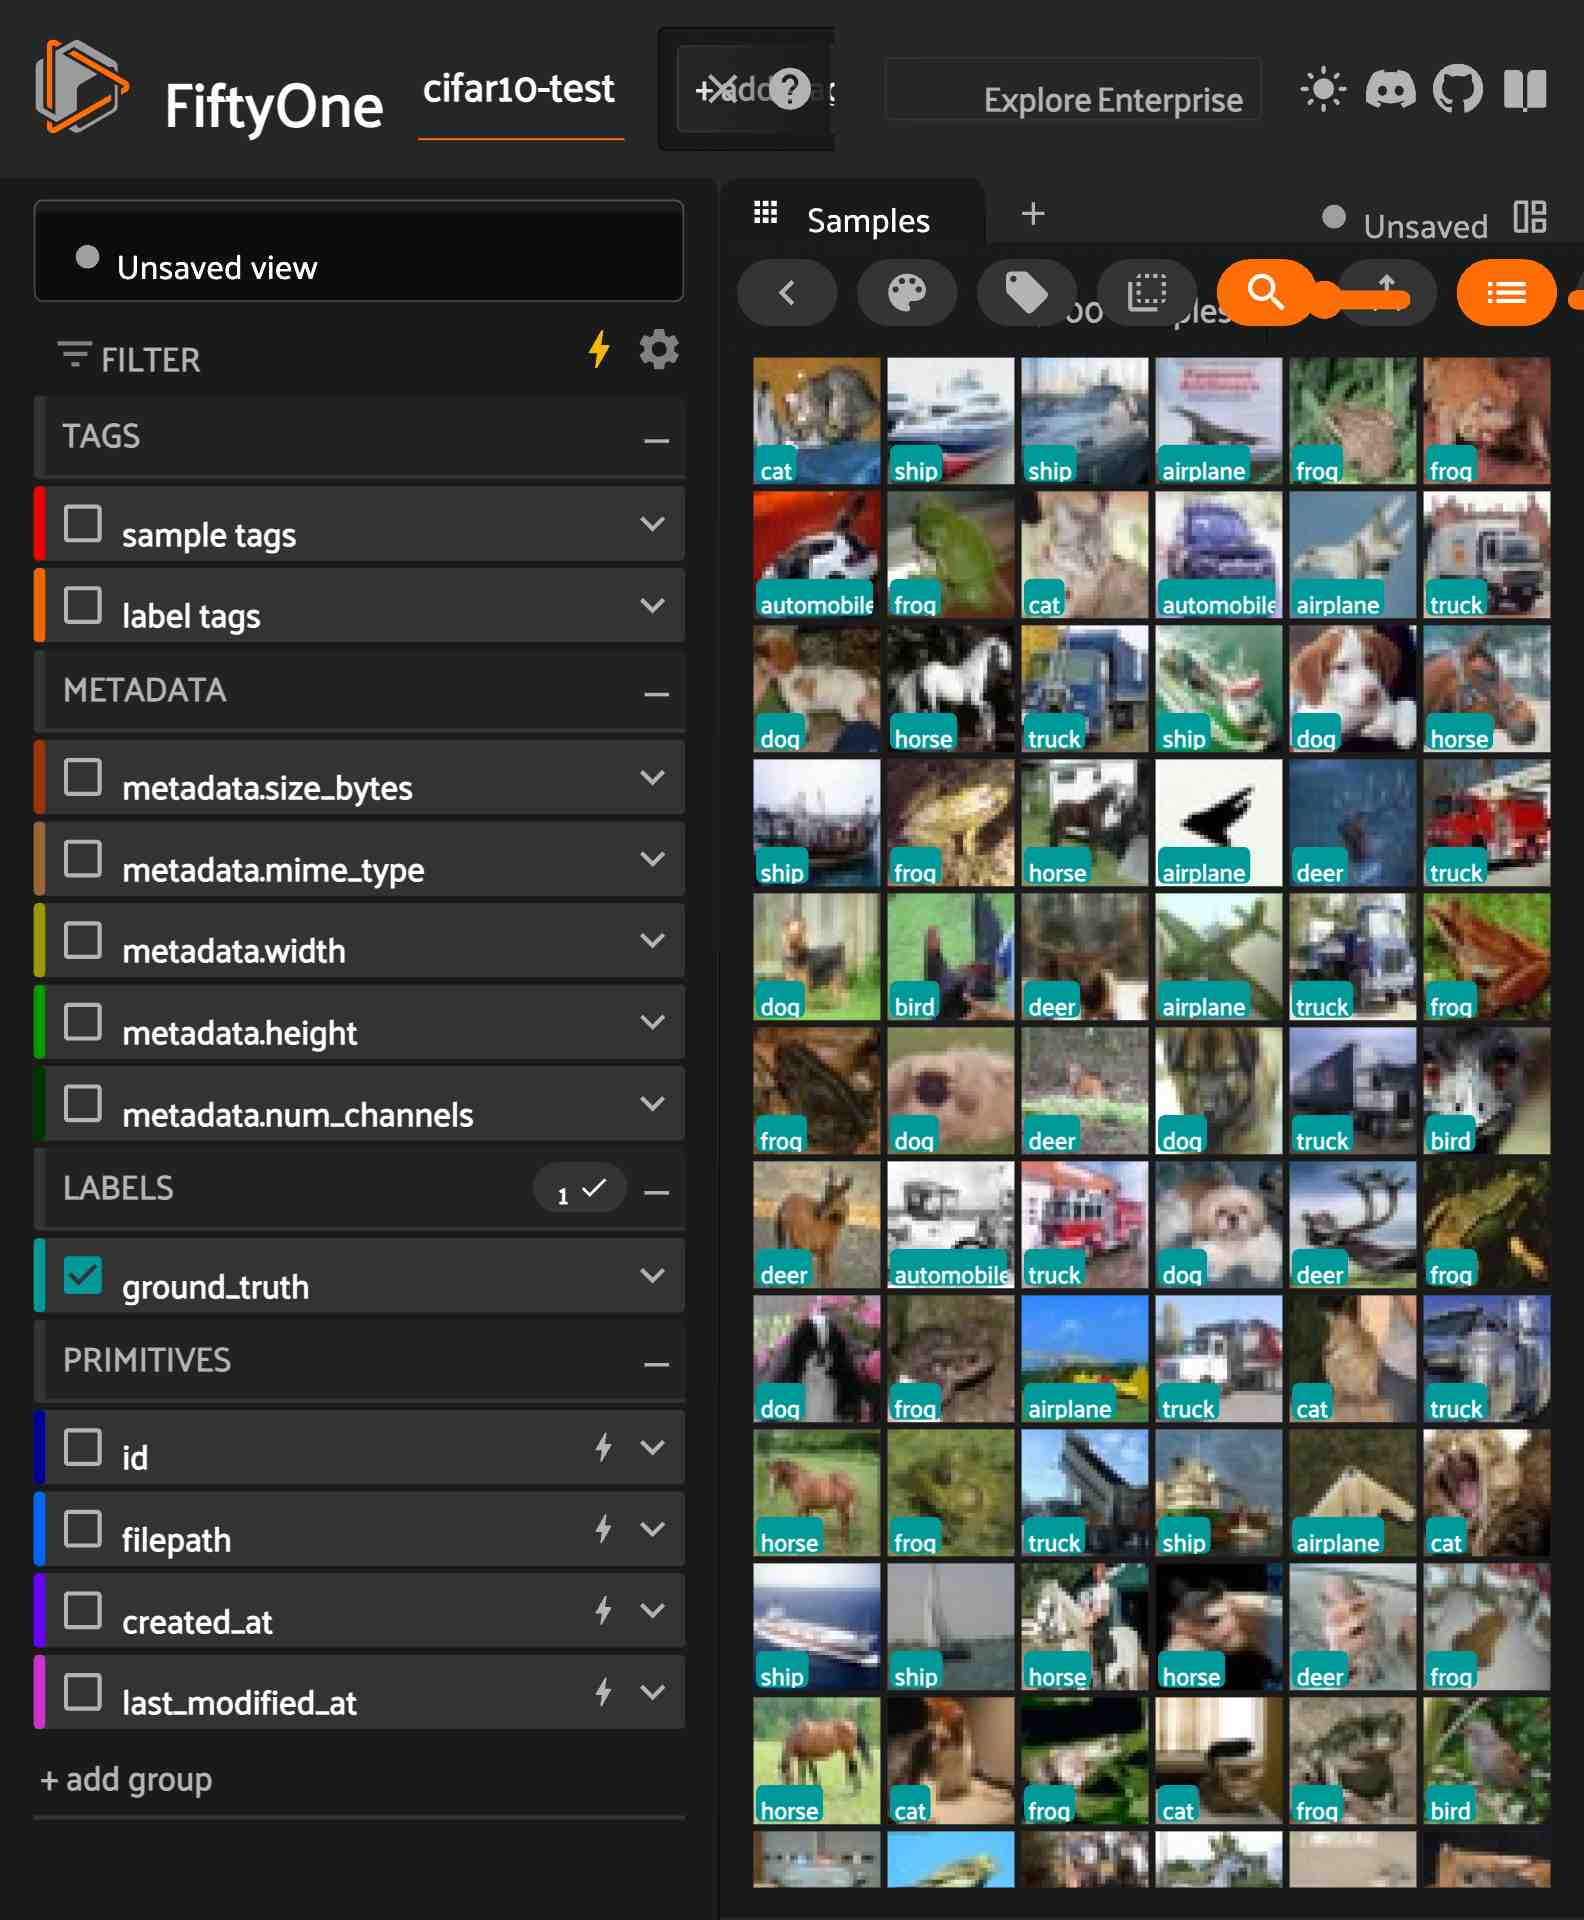

In [14]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("cifar10", split="test", overwrite=True)

session = fo.launch_app(dataset)

This time, we will use Open AI's CLIP model to do zero-shot classification on our images. We will use the [model zoo](https://docs.voxel51.com/model_zoo/models.html#clip-vit-base32-torch) to load this model:

In [16]:
import fiftyone.zoo as foz

classes = ["horse", "truck", "deer", "automobile", "bird", "ship", "cat", "dog", "frog", "airplane"]

clip = foz.load_zoo_model(
    "clip-vit-base32-torch",
    classes=classes,
)

first_5_samples = dataset.limit(5)

first_5_samples.apply_model(clip, label_field="clip")

results = first_5_samples.evaluate_classifications("clip")

# Print the same report to see the difference
results.print_report()

 100% |█████████████████████| 5/5 [131.9ms elapsed, 0s remaining, 37.9 samples/s]     
              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00         1
        bird       0.00      0.00      0.00         0
         cat       1.00      1.00      1.00         1
        frog       1.00      1.00      1.00         1
        ship       1.00      1.00      1.00         2

    accuracy                           0.80         5
   macro avg       0.60      0.60      0.60         5
weighted avg       0.80      0.80      0.80         5



## Evaluate for Segmentation

The last basic form of evaluation we will cover is evaluating segmentations! 

Once your dataset is prepped and ready with ground_truth and predicted segmentations, you can start evaluation!

### Instance Segmentation Example

For our example, we will load MSCOCO subset again, but this time with the instance segmentations on it as well:

In [61]:
!fiftyone datasets delete coco-2017-validation-25

Dataset 'coco-2017-validation-25' deleted


Found annotations at '/Users/dangural/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████████| 25/25 [279.9ms elapsed, 0s remaining, 89.3 samples/s]  
Dataset 'coco-2017-validation-25' created



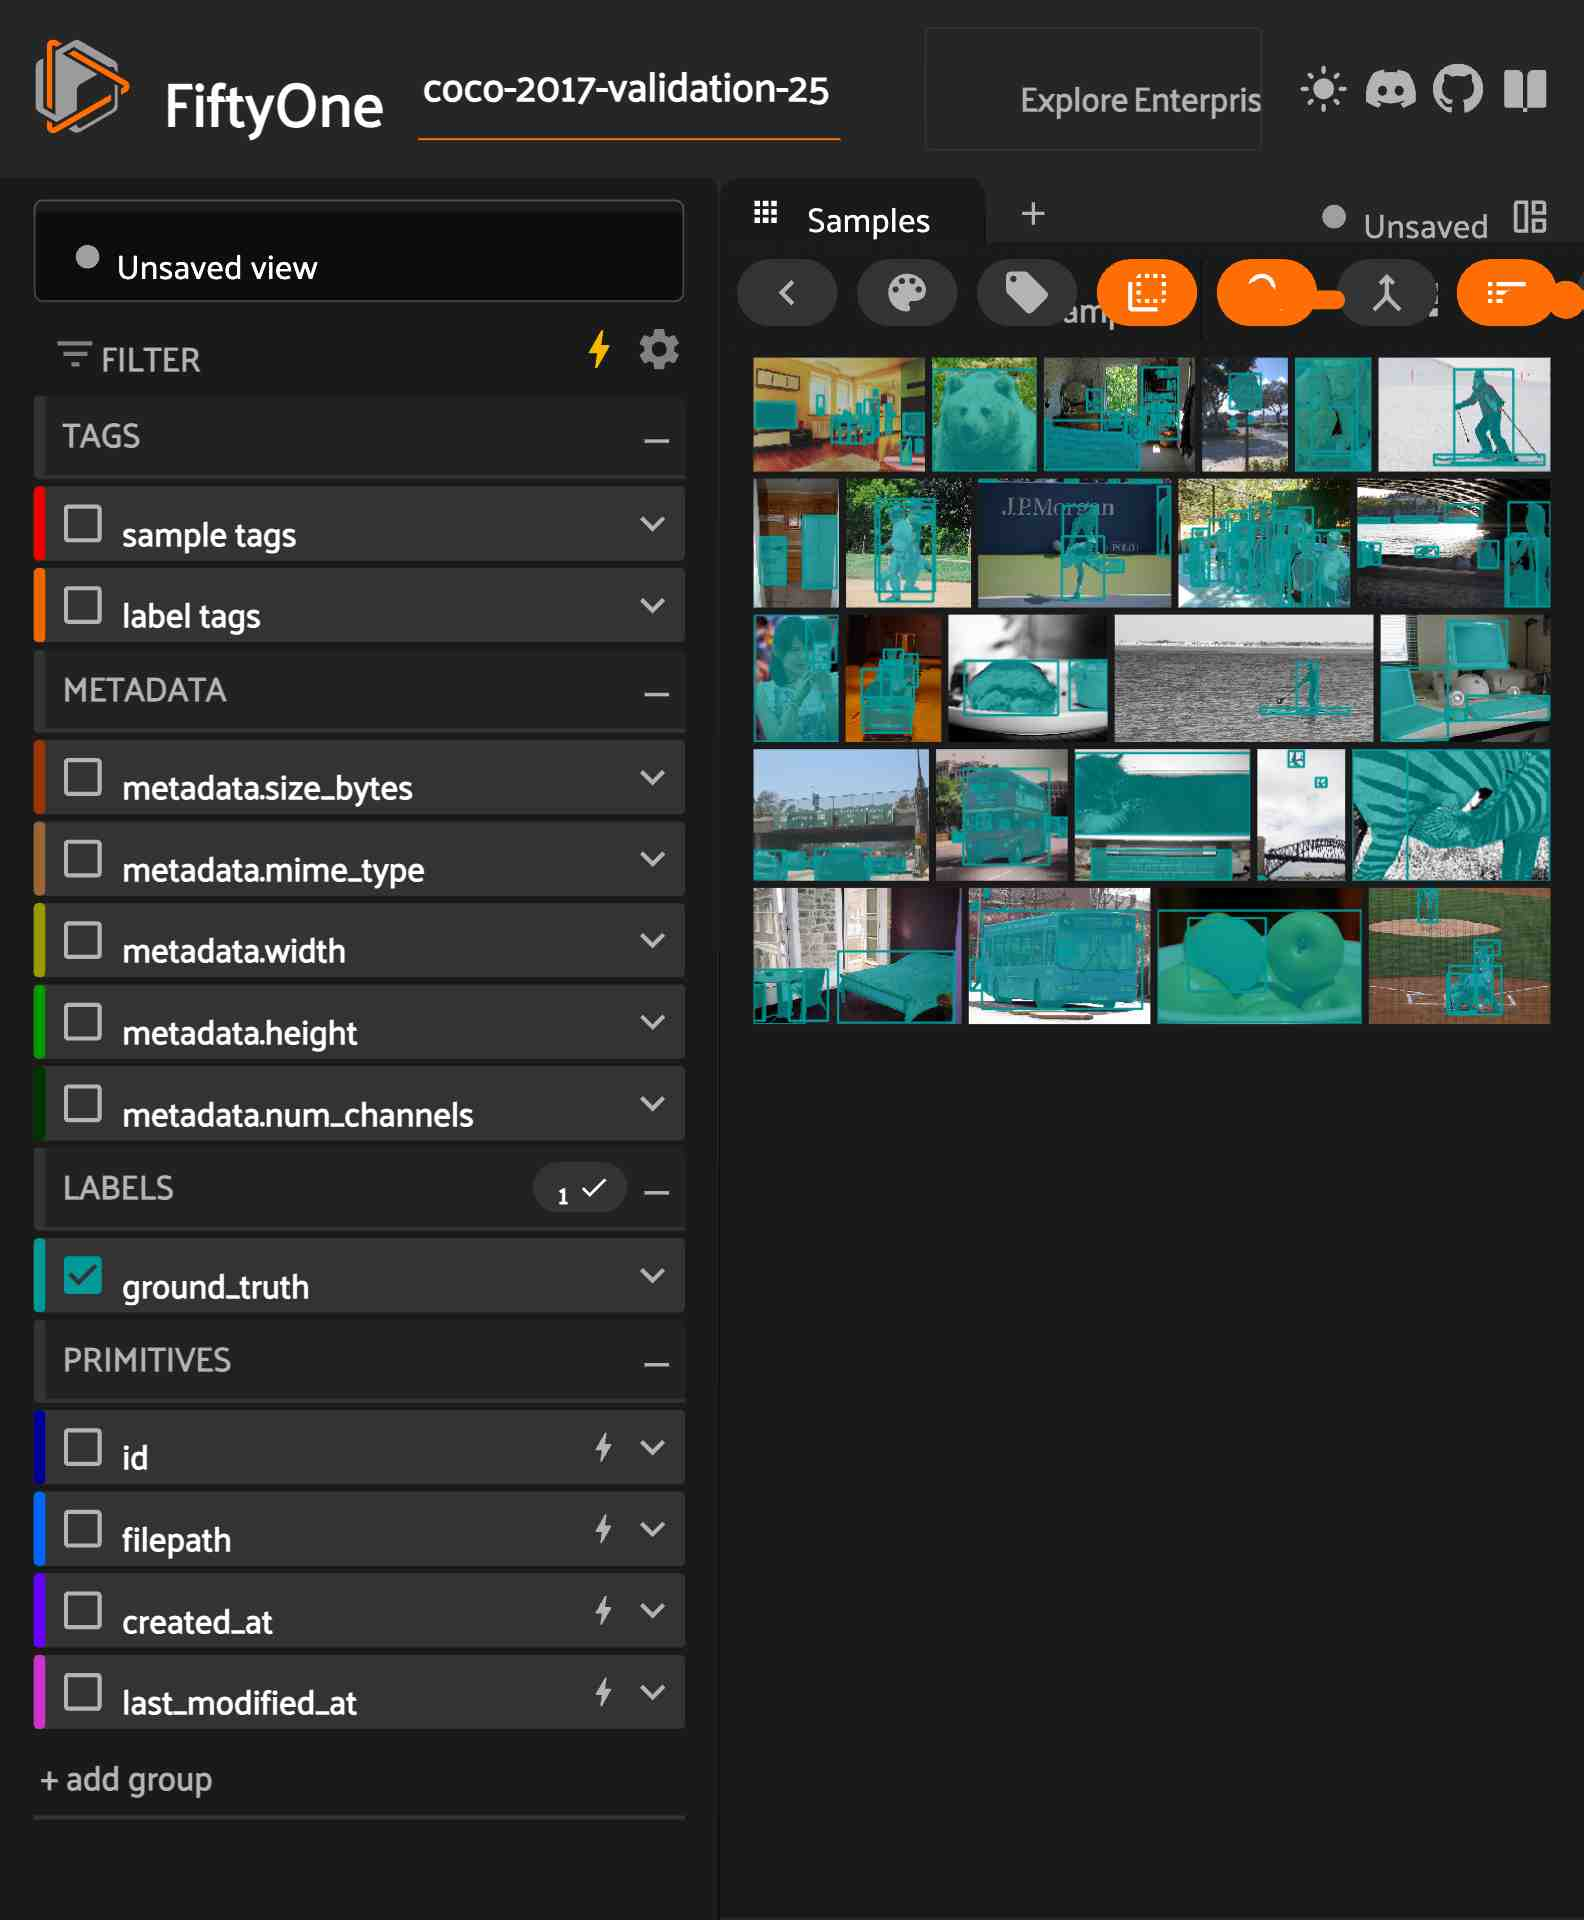

In [62]:
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["segmentations"],
    max_samples=25,
)

session.dataset = dataset

In order to evaluate, we need to add some predicted instance segmentations on our dataset. A light weight and easy to use model is [Ultralytics YOLO-11-seg](https://docs.ultralytics.com/models/yolo11/). This model was trained on MSCOCO and should perform well. It is also easy to use any Ultralytics model using our [integration](https://docs.voxel51.com/integrations/ultralytics.html) with them!

In [63]:
from transformers import Mask2FormerForUniversalSegmentation
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-small-coco-instance"
)
# Apply the model to the dataset and save predicted instance segmentations as "instances"
dataset.apply_model(model, label_field="semantic")

   0% ||------------------|  0/25 [1.6ms elapsed, ? remaining, ? samples/s] 

/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


 100% |███████████████████| 25/25 [9.0s elapsed, 0s remaining, 2.8 samples/s]      


### Semantic Segmentation Evaluation

Now let's look at an example of semantic segmentation. We can easily convert our instance segmentation dataset to semantic masks using [`to_segmentation()`](https://docs.voxel51.com/api/fiftyone.core.labels.html#fiftyone.core.labels.Detections.to_segmentation). After we convert our `ground_truth` and `instances` fields, we can evaluate our new masks! Let's convert now:

In [64]:
dataset.compute_metadata()
for sample in dataset:

    detections = sample["ground_truth"]
    segmentation = detections.to_segmentation(
        frame_size=(sample.metadata.width, sample.metadata.height),
        mask_targets=model.config.id2label,
    )
    sample["gt_semantic"] = segmentation
    sample.save()

Finally, we can evaluate our semantic segmentations with `dataset.evaluate_segmentations()`:

In [ ]:
results = dataset.evaluate_segmentations("gt_semantic", "semantic", eval_key="seg_eval")
results.print_report()

Computing possible mask values...
 100% |███████████████████| 25/25 [638.8ms elapsed, 0s remaining, 39.1 samples/s]      
Evaluating segmentations...
   8% |█/-----------------|  2/25 [123.7ms elapsed, 1.4s remaining, 16.2 samples/s] 

/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (426, 640) to match ground truth mask with shape (640, 426)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (640, 586) to match ground truth mask with shape (586, 640)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (483, 640) to match ground truth mask with shape (640, 483)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (500, 375) to match ground truth mask with shape (375, 500)
  warnings.warn(msg)


  28% |█████\-------------|  7/25 [376.0ms elapsed, 966.9ms remaining, 18.6 samples/s] 

/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (640, 428) to match ground truth mask with shape (428, 640)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (425, 640) to match ground truth mask with shape (640, 425)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (640, 424) to match ground truth mask with shape (424, 640)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (640, 621) to match ground truth mask with shape (621, 640)
  warnings.warn(msg)


  44% |████████/----------| 11/25 [616.2ms elapsed, 784.3ms remaining, 17.9 samples/s] 

/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (427, 640) to match ground truth mask with shape (640, 427)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (480, 640) to match ground truth mask with shape (640, 480)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (427, 640) to match ground truth mask with shape (640, 427)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (640, 427) to match ground truth mask with shape (427, 640)
  warnings.warn(msg)


  56% |██████████---------| 14/25 [766.9ms elapsed, 602.6ms remaining, 18.3 samples/s] 

/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (500, 375) to match ground truth mask with shape (375, 500)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (512, 640) to match ground truth mask with shape (640, 512)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (315, 640) to match ground truth mask with shape (640, 315)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (240, 320) to match ground truth mask with shape (320, 240)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/

  84% |███████████████/---| 21/25 [1.1s elapsed, 210.4ms remaining, 19.0 samples/s]    

/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (480, 640) to match ground truth mask with shape (640, 480)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (640, 427) to match ground truth mask with shape (427, 640)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (425, 640) to match ground truth mask with shape (640, 425)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (419, 640) to match ground truth mask with shape (640, 419)
  warnings.warn(msg)


 100% |███████████████████| 25/25 [1.4s elapsed, 0s remaining, 18.5 samples/s]         


/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (480, 640) to match ground truth mask with shape (640, 480)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (427, 640) to match ground truth mask with shape (640, 427)
  warnings.warn(msg)
/Users/dangural/anaconda3/envs/tcv/lib/python3.11/site-packages/fiftyone/utils/eval/segmentation.py:650: UserWarning: Resizing predicted mask with shape (480, 640) to match ground truth mask with shape (640, 480)
  warnings.warn(msg)


              precision    recall  f1-score   support

           2       0.44      0.62      0.51   27098.0
           4       0.00      0.00      0.00   11183.0
           5       1.00      0.34      0.51  932320.0
           6       0.00      0.00      0.00   76013.0
           7       0.64      0.00      0.00  440363.0
           8       1.00      0.12      0.21   41269.0
           9       1.00      0.19      0.32    2332.0
          11       0.99      0.11      0.19  151804.0
          13       0.00      0.00      0.00    7532.0
          14       0.96      0.57      0.71    1866.0
          15       1.00      0.92      0.96  156333.0
          21       1.00      0.74      0.85  375040.0
          22       1.00      0.77      0.87  272000.0
          24       0.20      0.11      0.14    2729.0
          25       0.00      0.00      0.00    1655.0
          26       0.89      0.66      0.75   18416.0
          27       0.00      0.00      0.00       0.0
          30       0.89    

## Conclusion

This covers the basic of model eval in FiftyOne. In the next step, we will learn how to dive even deeper with the [Model Evaluation Panel](https://docs.voxel51.com/user_guide/evaluation.html#model-evaluation-panel-sub-new), a interactive tool that allows you find exactly where your model is doing the best and the worst all in the FiftyOne app. Learn more by continuing!